# Report task 3: Compare my model to Google's model

## Introduction

The purpose of this report is to compare a Deep Learning model to a model created by the Teachable Machine by Google

In this file you will find some code written in comments. This is code that is only necessary to run on Streamlit. The version on Streamlit will have that code not in comments. 

Streamlit link:  https://rafengelenaitask3.streamlit.app

## Scraping for images

First of all, I need images so that I can train our Deep Learning model. This needs a lot of images (100+) and the more images gathered, the better the model is trained. 

In [1]:
import fastbook
fastbook.setup_book()
import os
from fastbook import *

Next we need our different categories we want to train the model for. I have chosen to characters in Star Wars. So the goal of our algorithm is to tell which character there is on an image. For structure, i create a folders. The main "images" folder and there are folders for each category.

In [2]:
categories=["Darth Vader", "Yoda", "Luke Skywalker", "R2D2", "C3PO"]
data_dir="./images/"
def setup_directories(categories):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    for category in categories:
        directory_path = data_dir+category.replace(" ", "_")
        print(directory_path)
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
    

setup_directories(categories)

./images/Darth_Vader
./images/Yoda
./images/Luke_Skywalker
./images/R2D2
./images/C3PO


I have chosen not to create a regular web scraper to get images. I use fastbook, with this module i can connect to some API's, the API i am sending requests to is the DuckDuckGo images API. After some testing I have noticed that with regular web scrapers, the program quits after a set amount of images. For Google this was 20 and for Bing this was 35. If i wanted to gather 100+ images per category, i would have to make multiple web scrapers, so this seemed as the better option.

First i loop through the categories to gain 150 results. I have chosen 150 images, because I have noticed that not all the images can be downloaded this way. That's why I've chosen a number bigger than 100 and after executing the program I also have more than 100 images left.

After that I loop through all the image links and I send a get request to get the image. I check for errors and also for if the response status is 200. I save the image in the correct folder with a unique name. I also print errors in case they happen.

In [3]:
category_names = []
def get_images(categories):

    for category in categories:
        # Search on DuckDuckGo for images of current category
        results = search_images_ddg(category, max_images=150)
        save_and_check_image(category=category, results=results)

def save_and_check_image(category, results):
    #setup directory path to save images, each category has it's own directory
    
    category_name = category.replace(" ","_")
    directory_path = data_dir+category_name
    category_names.append(category_name)
    # number of correctly downloaded image
    img_number=1

    #loop through all links and catch errors that may occur
    for index, link in enumerate(results):
        try:
            # get the images
            response = requests.get(link, timeout=10)

            # Check if the request was successful 
            if response.status_code == 200:

                # Get file extension and check if they are a correct image extension
                file_extension = link.split('.')[-1]
                if file_extension in ["jpeg", "jpg", "png"]:

                    # Save the image to a file with img_number as a identifier
                    filename = f"{category_name}_duckduckgo_{img_number}.{file_extension}"
                    filepath = os.path.join(directory_path, filename)
                    
                    with open(filepath, 'wb') as file:
                        for chunk in response.iter_content(chunk_size=128):
                            file.write(chunk)
                
                    
                    print(f"Image {index + 1} downloaded: {filename}")
                    img_number+=1
            else:
                print(f"Invalid response status for image {index+1}: {response.status_code}")
        except Exception as e:
            print(f"Error downloading image {index+1}: {str(e)}")
            continue

get_images(categories)

Image 1 downloaded: Darth_Vader_duckduckgo_1.jpg
Image 2 downloaded: Darth_Vader_duckduckgo_2.png
Image 3 downloaded: Darth_Vader_duckduckgo_3.jpg
Image 4 downloaded: Darth_Vader_duckduckgo_4.jpg
Image 5 downloaded: Darth_Vader_duckduckgo_5.jpg
Image 6 downloaded: Darth_Vader_duckduckgo_6.jpg
Image 7 downloaded: Darth_Vader_duckduckgo_7.jpg
Image 8 downloaded: Darth_Vader_duckduckgo_8.jpg
Image 9 downloaded: Darth_Vader_duckduckgo_9.jpg
Image 10 downloaded: Darth_Vader_duckduckgo_10.png
Image 11 downloaded: Darth_Vader_duckduckgo_11.png
Image 12 downloaded: Darth_Vader_duckduckgo_12.jpg
Image 13 downloaded: Darth_Vader_duckduckgo_13.jpg
Invalid response status for image 14: 403
Image 15 downloaded: Darth_Vader_duckduckgo_14.jpg
Image 16 downloaded: Darth_Vader_duckduckgo_15.jpg
Image 17 downloaded: Darth_Vader_duckduckgo_16.jpg
Image 19 downloaded: Darth_Vader_duckduckgo_17.jpg
Image 20 downloaded: Darth_Vader_duckduckgo_18.jpg
Image 21 downloaded: Darth_Vader_duckduckgo_19.jpg
Image 2

Now the dataset for our program is complete.

## EDA & Prep the data

### EDA

Here I show how many images there are for each category. After that I use MatPlotLb to show some of the images.

In [4]:
import matplotlib.pyplot as plt

Now I want to validate that all images can be loaded. During the creation of this program, I have gotten some errors with training the model. With this extra check the errors are gone.

In [8]:
def check_image(img_path):
    # try to load images + make images RGBA 
    try:
        img = Image.open(img_path)
        img.load()

        if img.mode != "RGBA":
            img = img.convert("RGBA")
        img.close()
        
    except (IOError, OSError) as e:
        print(f"Error loading image at path: {img_path}")
        if os.path.exists(img_path):
            os.remove(img_path)

#check every image
for category in category_names:

    category_path = os.path.join(data_dir, category)
    image_files = os.listdir(category_path)
    for image_file in image_files:
        full_path = category_path+"/"+image_file
        check_image(full_path)

    

I count the amount of images that are left and display a few of them.

Category: Darth_Vader, Number of Images: 124
Category: Yoda, Number of Images: 134
Category: Luke_Skywalker, Number of Images: 114
Category: R2D2, Number of Images: 113
Category: C3PO, Number of Images: 106


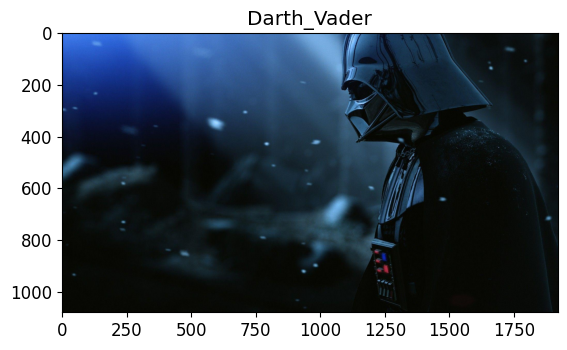

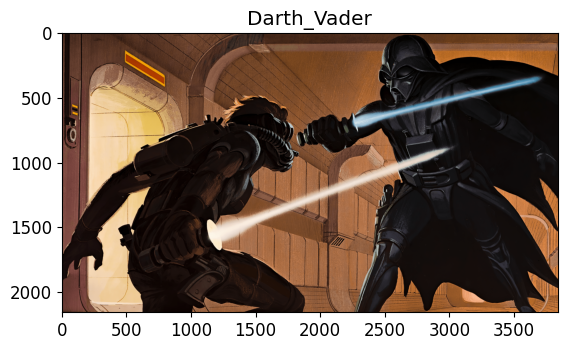

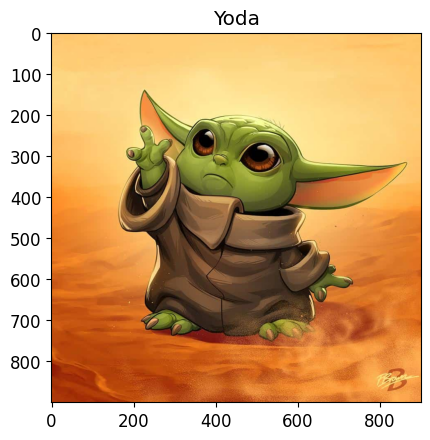

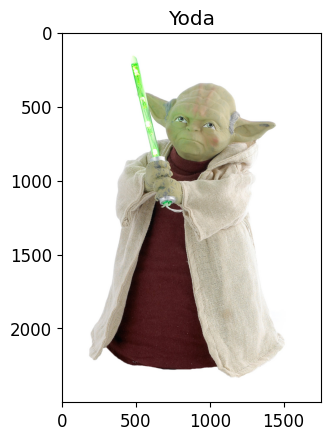

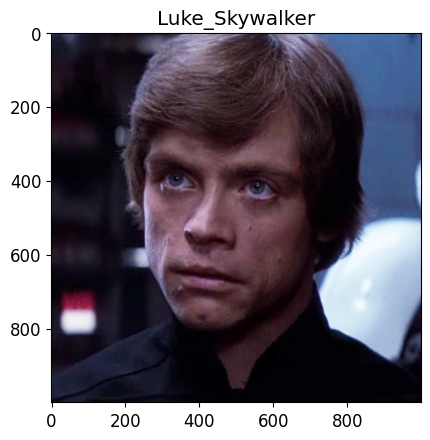

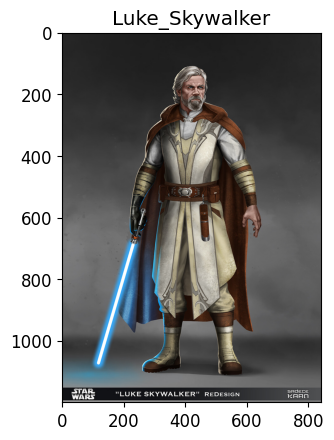

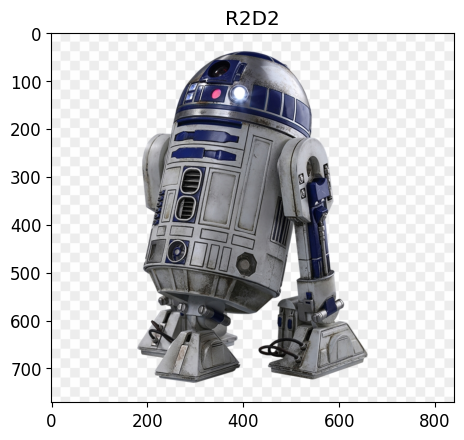

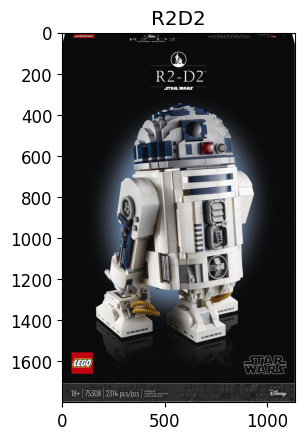

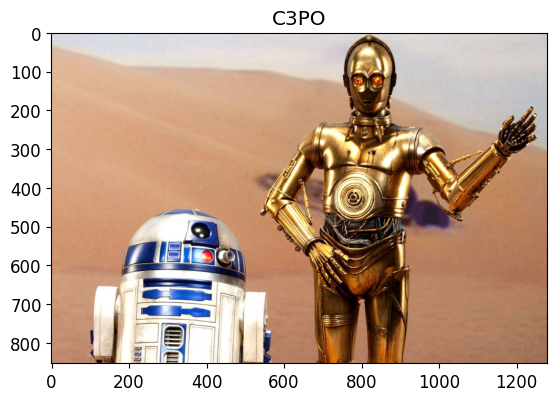

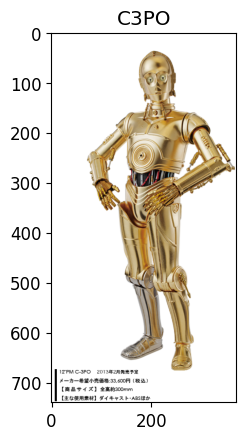

In [9]:
def count_images(category_names):
    
    directories= []
    #counts amount of images per directory/category
    for category in category_names:
        category_path = os.path.join(data_dir, category)
        num_images = len(os.listdir(category_path))
        print(f"Category: {category}, Number of Images: {num_images}")

        
        directories.append(category_path)

    display_images(category_names)

#shows 2 images per category
def display_images(category_names, amount_category_images=2):
    for category in category_names:


        category_path = os.path.join(data_dir, category)
        image_files = os.listdir(category_path)[:amount_category_images] 
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            image = Image.open(image_path)
            plt.imshow(image)
            plt.title(category)
            plt.show()
    
count_images(category_names)

### Prep the data



The images are in directories according to their category, not according to training and testing dataset. We can use DataFrames with the ImageDataGenerator (ImageDataGenerator, z.d.).This will however give us some problems with Teachable Machine. We don't know which images are going in which dataset so we will split the images according to directories. 

In [10]:
import os
import shutil
import random

def split_images(train_dir="./images/train", test_dir="./images/test", split_ratio=0.9):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(train_dir, exist_ok=True)
    
    for category in categories:
        category=category.replace(" ", "_")
        category_dir = os.path.join(data_dir, category)
        
        # Create train and test directories for each category
        train_class_dir = os.path.join(train_dir, category)
        os.makedirs(train_class_dir, exist_ok=True)

        test_class_dir = os.path.join(test_dir, category)
        os.makedirs(test_class_dir, exist_ok=True)

        files = os.listdir(category_dir)

        num_train_files = int(len(files) * split_ratio)

        random.shuffle(files)
        # put images in train and test directories based upon the split ratio
        for file in files[:num_train_files]:
            src_path = os.path.join(category_dir, file)
            dst_path = os.path.join(train_class_dir, file)
            shutil.move(src_path, dst_path)

       
        for file in files[num_train_files:]:
            src_path = os.path.join(category_dir, file)
            dst_path = os.path.join(test_class_dir, file)
            shutil.move(src_path, dst_path)




split_images()

I create datasets based on the different directories.

In [11]:
from keras.preprocessing.image import ImageDataGenerator


def create_data_sets():

    train_val_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale = 1./255)


    train_dir ='./images/train'
    test_dir='./images/test'
    
    train_ds = train_val_datagen.flow_from_directory(
        directory=train_dir,
        subset='training',
        target_size = (64, 64),
        batch_size = 32,
        class_mode = 'categorical'
    )


    validation_ds = train_val_datagen.flow_from_directory(
        directory=train_dir,
        subset='validation',
        target_size = (64, 64),
        batch_size = 32,
        class_mode = 'categorical'
    )


    test_ds = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size = (64, 64),
        batch_size = 32,
        class_mode = 'categorical'
    )
    return train_ds, test_ds, validation_ds
training_set, test_set, validation_set = create_data_sets()


Found 424 images belonging to 5 classes.
Found 105 images belonging to 5 classes.
Found 62 images belonging to 5 classes.


## Design a CNN

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set the number of classes
NUM_CLASSES = 1

# Create a sequential model with a list of layers
model = models.Sequential([
    layers.Conv2D(64, (3, 3), input_shape=(64, 64, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)     

## Train model

In [14]:
history = model.fit(training_set,
                validation_data = validation_set,
                steps_per_epoch = 10,
                epochs = 20
                )


Epoch 1/20




c:\Users\rafen\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 [==============================] - 11s 969ms/step - loss: 0.9128 - accuracy: 0.7270 - val_loss: 0.6001 - val_accuracy: 0.8000
Epoch 2/20
10/10 [==============================] - 9s 961ms/step - loss: 0.5377 - accuracy: 0.8000 - val_loss: 0.5607 - val_accuracy: 0.8000
Epoch 3/20
10/10 [==============================] - 9s 923ms/step - loss: 0.5250 - accuracy: 0.8000 - val_loss: 0.5380 - val_accuracy: 0.8000
Epoch 4/20
10/10 [==============================] - 9s 851ms/step - loss: 0.5119 - accuracy: 0.8000 - val_loss: 0.5430 - val_accuracy: 0.8000
Epoch 5/20
10/10 [==============================] - 9s 937ms/step - loss: 0.5099 - accuracy: 0.8000 - val_loss: 0.5574 - val_accuracy: 0.8000
Epoch 6/20
10/10 [==============================] - 10s 974ms/step - loss: 0.5076 - accuracy: 0.8000 - val_loss: 0.5447 - val_accuracy: 0.8000
Epoch 7/20
10/10 [==============================] - 10s 952ms/step - loss: 0.5062 - accuracy: 0.8000 - val_loss: 0.5414 - val_accuracy: 0.8000
Epoch 8/20
10/

In [18]:
from keras.models import load_model 
model.save("models/modelStarWars.tf")
model = load_model("models/modelStarWars.tf")

INFO:tensorflow:Assets written to: models/modelStarWars.tf\assets


INFO:tensorflow:Assets written to: models/modelStarWars.tf\assets


## Comparison

### Teachable Machine

First I will load in the Teachable Machine model. I have created this using the same training set. The code is provided on the Teachable Machine website when exporting the model.

In [24]:
 # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

def setup_tm():
    # Disable scientific notation for clarity
    np.set_printoptions(suppress=True)

    # Load the model
    tm_model = load_model("./models/teachable_machine/keras_model.h5", compile=False)

    tm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return tm_model
tm_model = setup_tm()



Here you can see 2 figures of the loss and the accuracy of the history of the model.

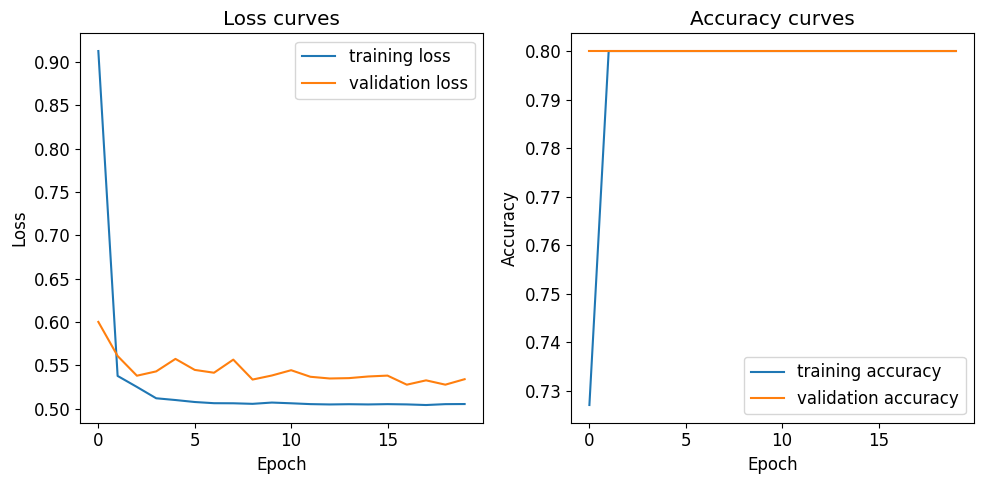

In [25]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()


fig.tight_layout()


plt.show()

### Testing

Now I will use the test dataset to test both the Teachable Machine and my own model.

In [31]:

test_loss, test_acc = model.evaluate(test_set)
print('My model, test accuracy :', test_acc)
print('My model, test loss :', test_loss)

test_loss_tm, test_acc_tm = tm_model.evaluate(test_set)
print('Teachable Machine, test accuracy:', test_acc_tm)
print('Teachable Machine, test loss:', test_loss_tm)


data = {
    'Accuracy': [test_acc, test_acc_tm],
    'Loss': [test_loss, test_loss_tm]
}

df = pd.DataFrame(data, index=['My Model', 'Teachable Machine'])


2/2 [==============================] - 2s 940ms/step - loss: 0.5305 - accuracy: 0.8000
My model, test accuracy : 0.7999999523162842
My model, test loss : 0.5305071473121643
2/2 [==============================] - 2s 580ms/step - loss: 1.5608 - accuracy: 0.2581
Teachable Machine, test accuracy: 0.25806450843811035
Teachable Machine, test loss: 1.56084144115448


As you can see, my model scores has a higher accuracy than the Teachable Machine by Google. I am perplexed by this, because i don't think the numbers are accurate. 25% accuracy is very low, especially for the Teachable Machine which is a good Deep Learning Algorithm.

## Streamlit

This is what i show on Streamlit. On streamlit, the program will not scrape images and create a new model. The model that we have saved in this document will be added to streamlit.

In [32]:
import streamlit as st
st.header('Raf Engelen - r0901812 - 3APP01', divider='gray')
st.title("Task 3 ML: Comparing Deep Learning model to Teachable Machine")
st.write('''As you can see, my model scores has a higher accuracy than the Teachable Machine by Google. I am perplexed by this, because i don't think the numbers are accurate. 25% accuracy is very low, especially for the Teachable Machine which is a good Deep Learning Algorithm.''')
st.write(df)


## GenAI tools

I needed a quick reminder how I could show images in python.

![prompt1](prompt1.png)

![answer1](answer1.png)

After putting all the images in directories per category, I had to split them up in a training set and a testing set. This was no problem with the current structure. But the problem was that i didn't know which images were used for training, so i couldn't train the Teachable Machine properly. That's why i wanted to move the images to a test and a train directory.

![prompt2](prompt2.png)

![answer2](answer21.png)

![answer2](answer22.png)



## Literatuurlijst

ImageDataGenerator. (z.d.). tensorflow. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe

Teachable machine. (z.d.). https://teachablemachine.withgoogle.com/